## Prepare imports

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from models.vae import BaseModel as VAE
from models.encoder import BaseModel as Encoder

from layers.ect import EctLayer, EctConfig
from layers.directions import generate_directions
from load_configs import load_config
from datasets import load_datamodule

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}



encoder_config = load_config("./configs/config_encoder_mnist.yaml")
vae_config = load_config("./configs/config_vae_mnist.yaml")


## Load Models and Data

In [8]:

dm = load_datamodule(encoder_config.data)

vae_model = VAE.load_from_checkpoint("./trained_models/vae_mnist.ckpt")

# (in_channels=vae_config.model.in_channels, latent_dim=vae_config.model.latent_dim,img_size=vae_config.layer.ect_size)

# # Load the VAE model

# metrics = get_mse_metrics()

# vae_litmodel = BaseVAE.load_from_checkpoint(
#     f"./trained_models/{vae_config.model.save_name}",
#     model=vae_model,
#     training_accuracy=metrics[0],
#     test_accuracy=metrics[1],
#     validation_accuracy=metrics[2],
#     accuracies_fn=compute_mse_accuracies,
#     loss_fn=compute_mse_loss_fn,
#     learning_rate=0.01,
#     layer=layer,
# ).to(DEVICE)


# Load the encoder 

# ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
#     f"./trained_models/{encoder_config.model.save_name}",
#     layer=layer,
#     ect_size=encoder_config.layer.ect_size,
#     hidden_size=encoder_config.model.hidden_size,
#     num_pts=encoder_config.model.num_pts,
#     num_dims=encoder_config.model.num_dims,
#     learning_rate=encoder_config.model.learning_rate,
# ).to(DEVICE)


TypeError: BaseModel.__init__() missing 4 required positional arguments: 'vaeconfig', 'ectconfig', 'max_epochs', and 'learning_rate'

In [ ]:
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

batch = Batch.from_data_list(data_list).to(DEVICE)

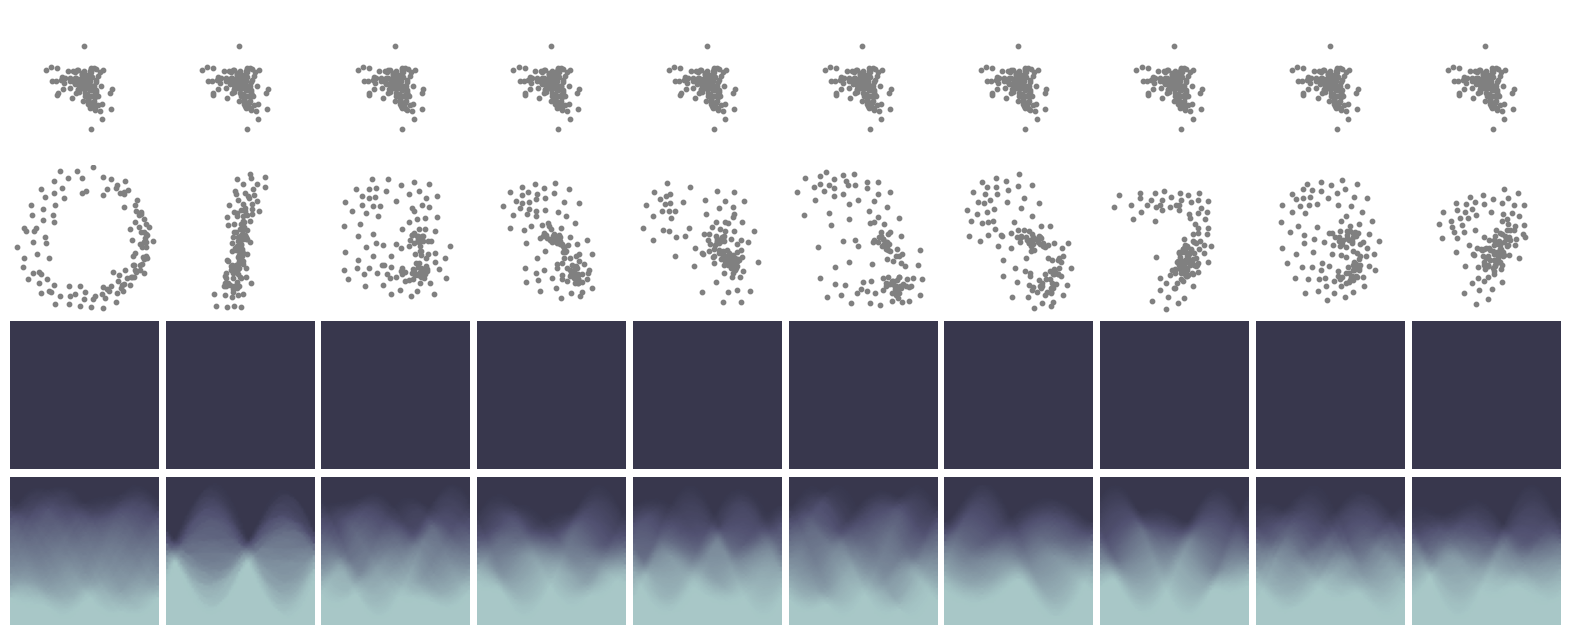

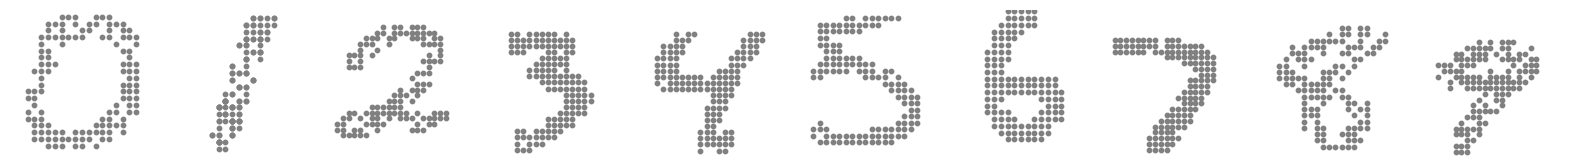

In [ ]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



ect = layer(batch,batch.batch).unsqueeze(1)

# with torch.no_grad():
#     decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# # Undo the VAE transform
# decoded = (decoded + 1 ) / 2

decoded = torch.zeros_like(ect)

with torch.no_grad():
    recon_vae_batch = ect_encoder_litmodel.model.forward(decoded.squeeze())
    recon_batch = ect_encoder_litmodel.model.forward(ect.squeeze())


fig, axes = plt.subplots(
    nrows=4, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)
    


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)

    ax = axis[0]
    ax.scatter(recon_vae_pts[:,0],recon_vae_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")


    # ax = axis[1]
    # ax.scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    # ax.set_xlim([-1,1])
    # ax.set_ylim([-1,1])
    # ax.set_aspect(1)
    # ax.axis("off")

    ax = axis[1]
    ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

    ax = axis[2]
    ax.imshow(recon_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")

    ax = axis[3]
    ax.imshow(orig_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")    

plt.savefig("./figures/img/mnist/reconstructed_mnist.svg",transparent=True)   



fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for orig_pts, recon_pts, recon_vae_pts,orig_img, recon_img,axis in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,ect,decoded,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax = axis
    ax.scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")

plt.savefig("./figures/img/mnist/mnist_base_pointclouds.svg",transparent=True)   


## Sample from VAE and reconstruct points 

In [ ]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
recon_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 2

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, figsize=(5,5)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for samples_pts,sample,ax in zip(recon_samples,samples,axes.T):
    samples_pts = samples_pts.view(-1,2).cpu().detach().squeeze().numpy()
    samples_pts = rotate(samples_pts, degrees=-90)
    ax[0].scatter(samples_pts[:,0],samples_pts[:,1],**PC_PLOT_CONFIG)
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].imshow(sample.squeeze().cpu().detach().numpy(),**ECT_PLOT_CONFIG)
    ax[1].axis("off")



plt.savefig("./figures/img/mnist/generated_samples.svg",transparent=True) 

NameError: name 'vae_litmodel' is not defined

# Stability of the ECT

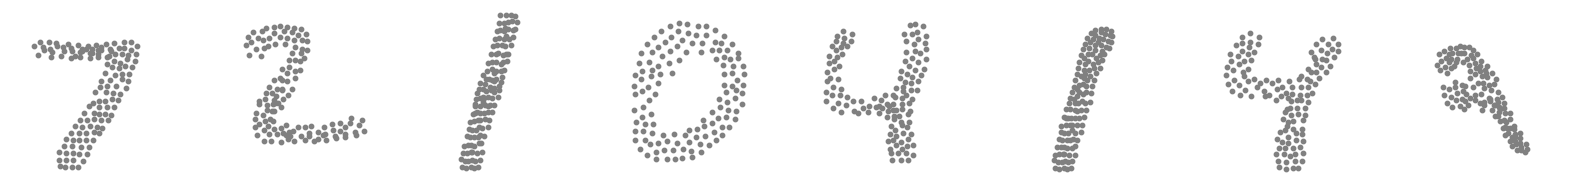

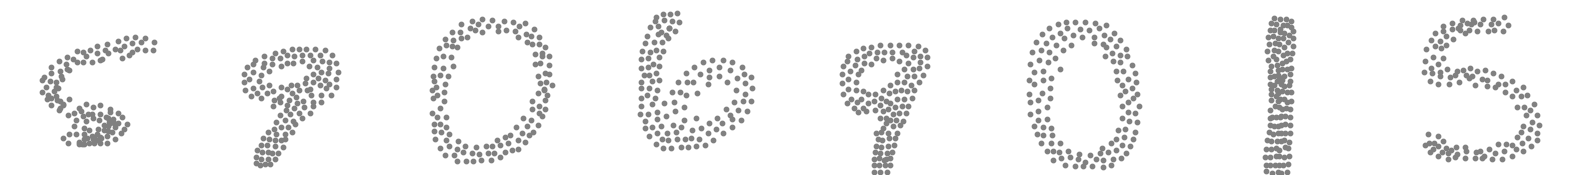

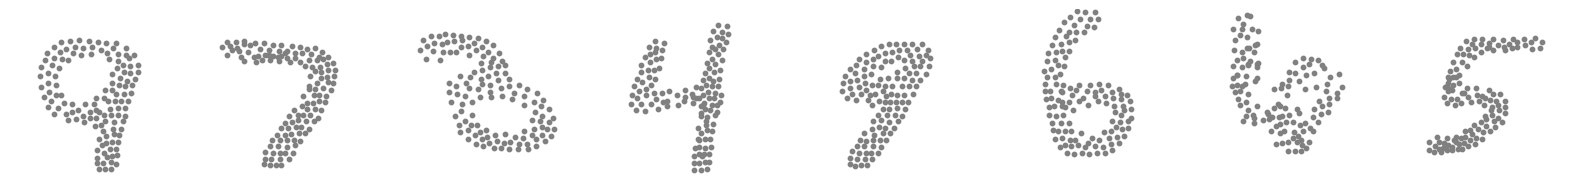

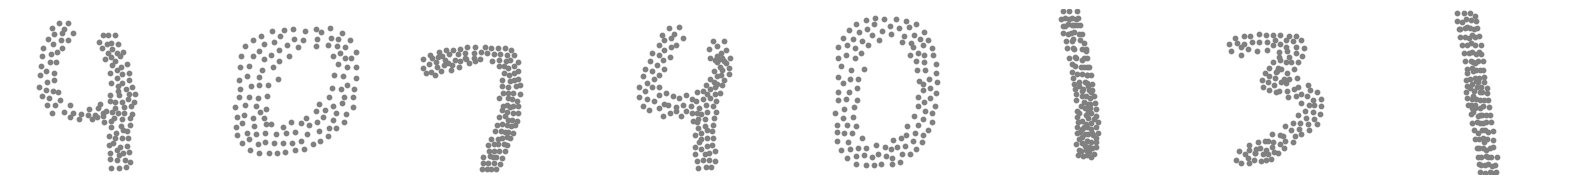

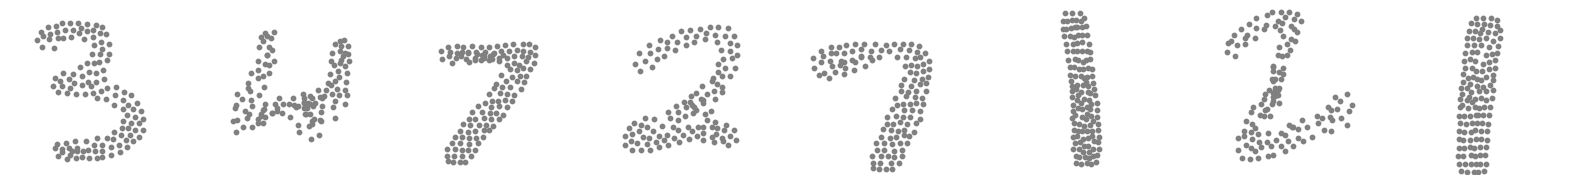

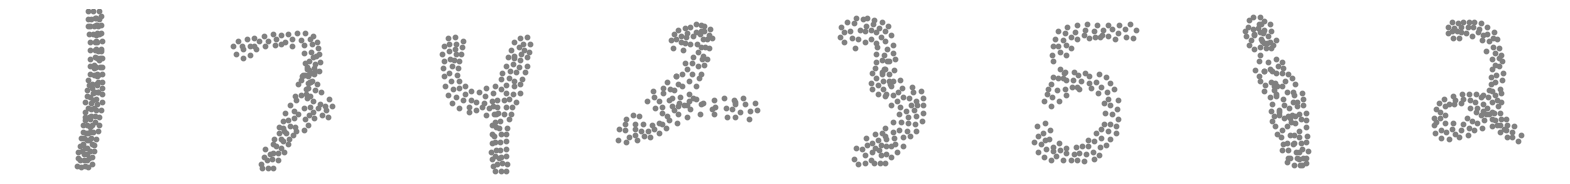

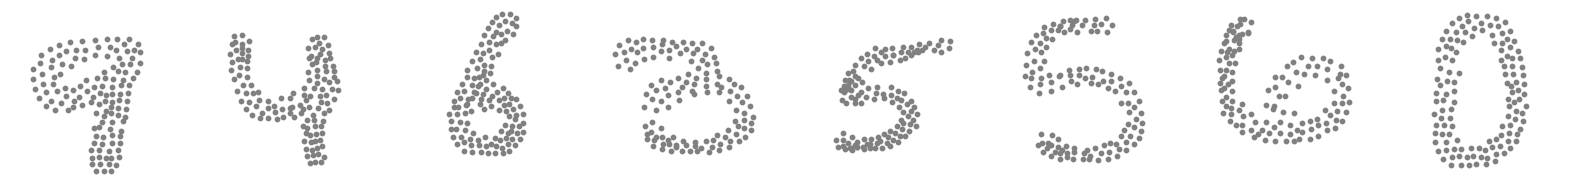

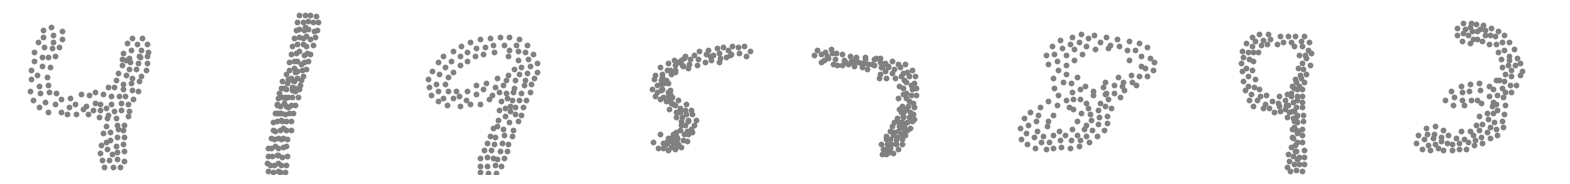

In [ ]:
data_loader = dm.test_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)

# Pass reconstruction through the point cloud decoder


def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )


    for recon_pts,ax in zip(recon_batch[idx::],axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)


        ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")

In [ ]:
from torch_geometric.data import Batch,Data
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

test_batch = Batch.from_data_list(data_list).to(DEVICE)

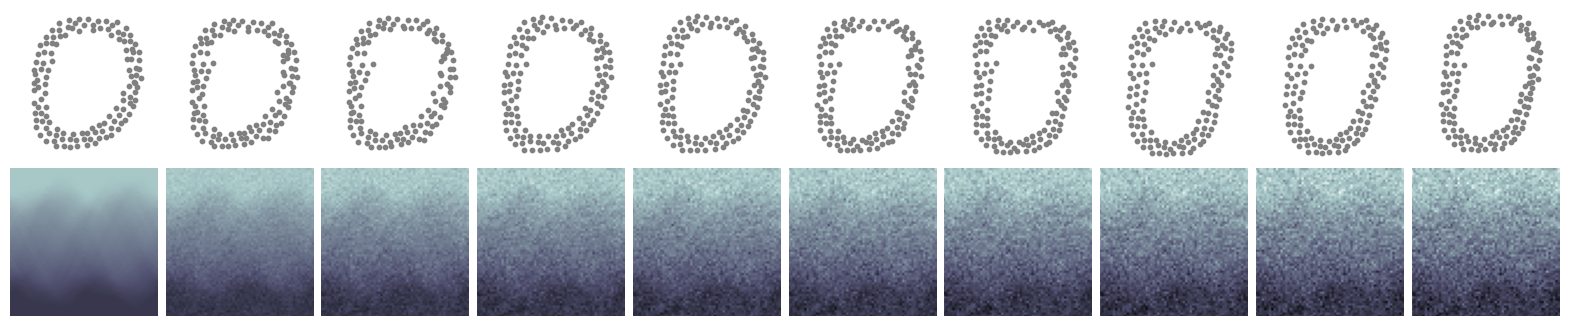

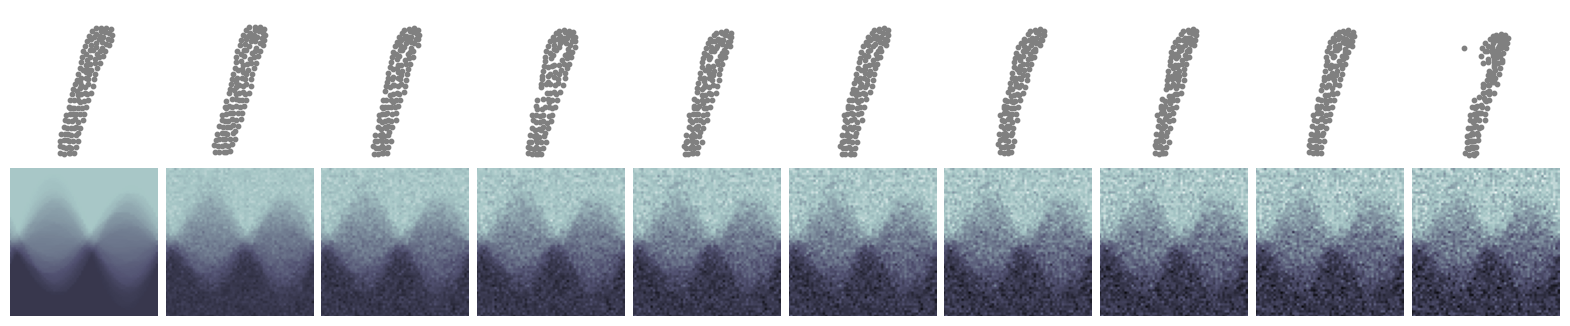

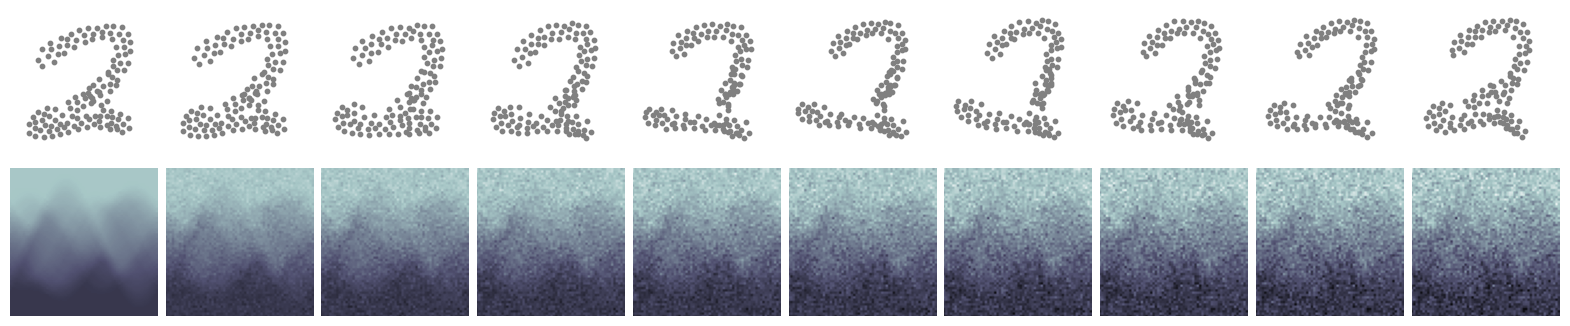

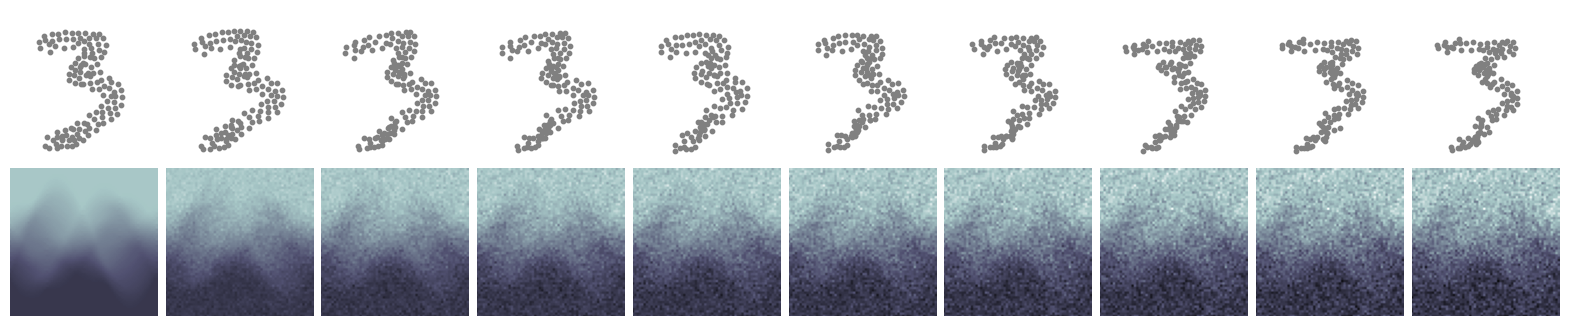

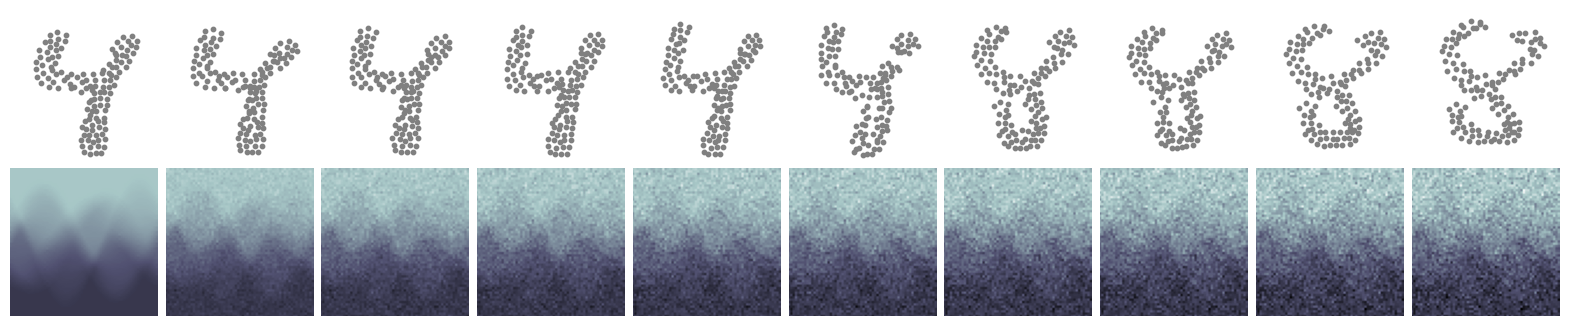

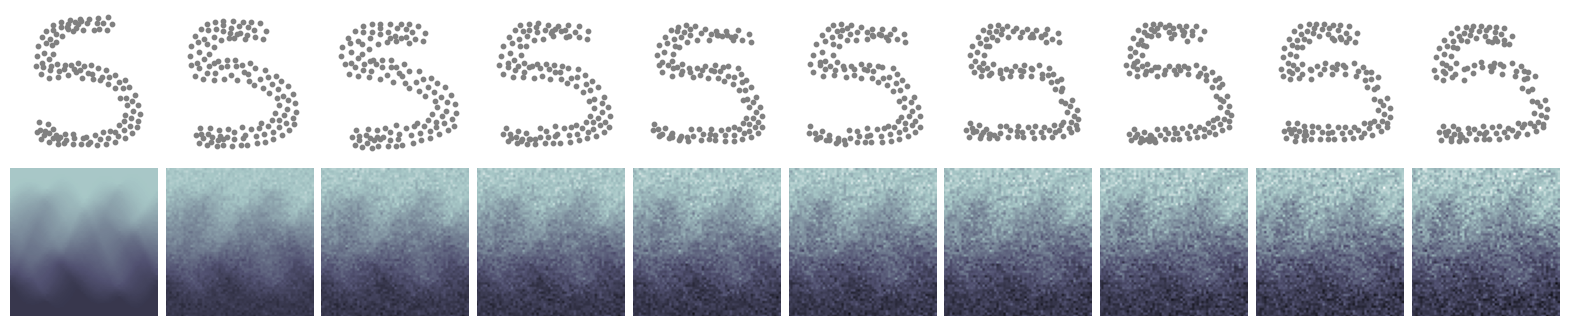

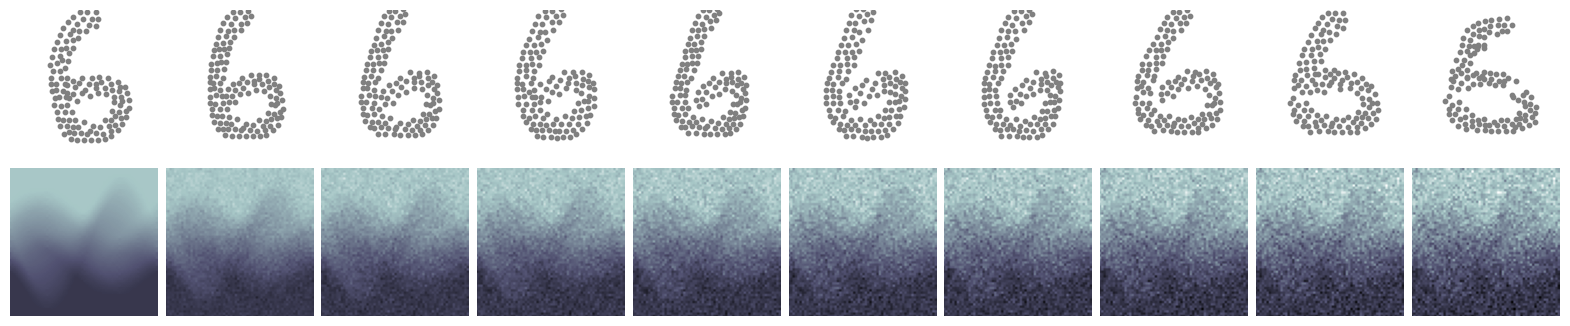

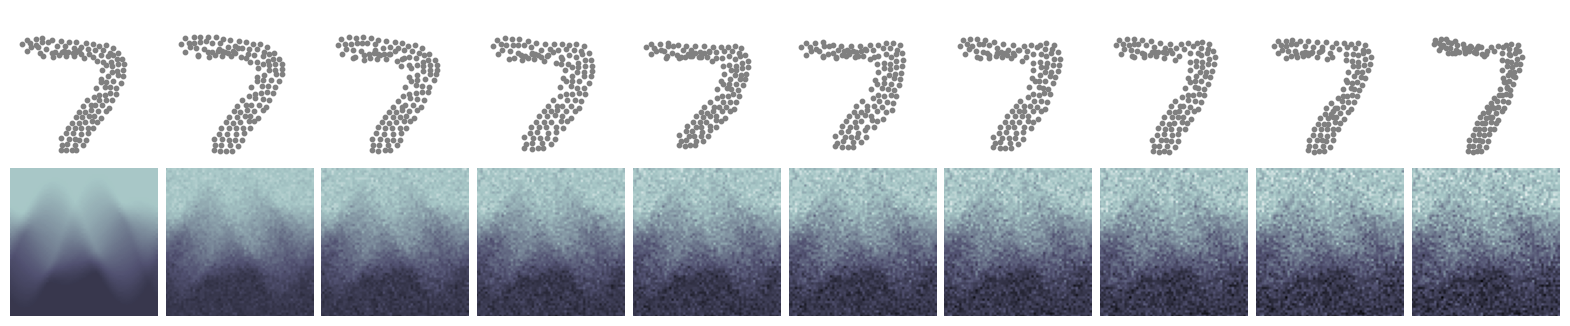

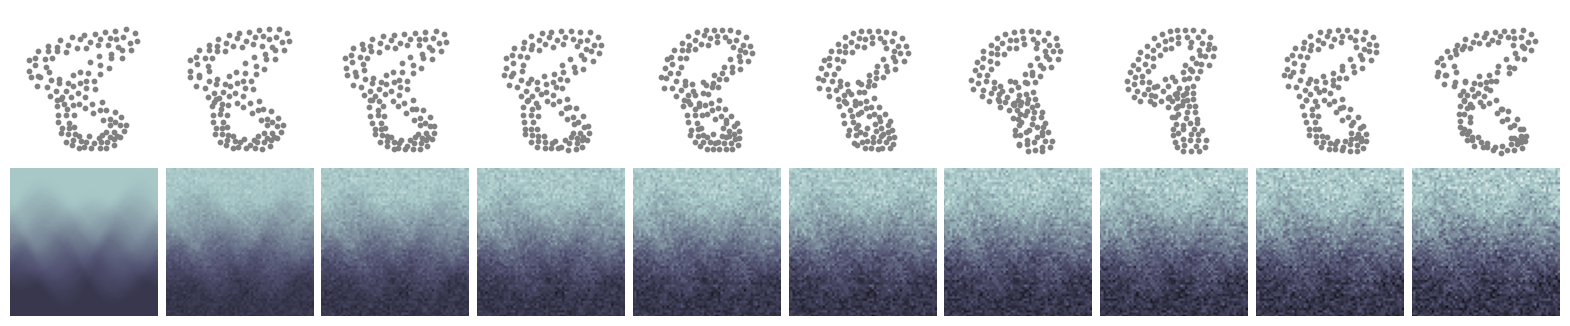

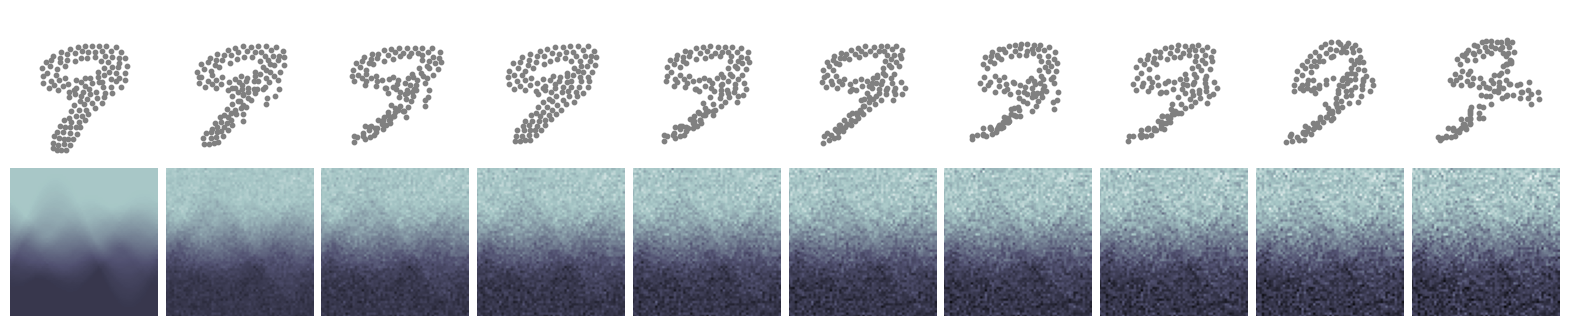

In [ ]:
base_ects = layer(test_batch,test_batch.batch).unsqueeze(1)


# for base_ect in base_ects:

for y, ect in enumerate(base_ects):

    ect_list = [ect]
    for _ in range(10):
        ect = ect + .05*torch.randn_like(ect)
        ect_list.append(ect)

    noise_batch = torch.vstack(ect_list)


    # Pass reconstruction through the point cloud decoder


    with torch.no_grad():
        recon_batch = ect_encoder_litmodel.model.forward(noise_batch)


    n_images = 10

    idx=0
    fig, axes = plt.subplots(
        nrows=2, ncols=n_images, figsize=(20,4)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)


    for recon_pts,ect,ax in zip(recon_batch[idx::],noise_batch,axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax[0].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax[0].set_xlim([-1,1])
        ax[0].set_ylim([-1,1])
        ax[0].set_aspect(1)
        ax[0].axis("off")

        ax[1].imshow(ect.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
        ax[1].set_xlim([0,64])
        ax[1].set_ylim([0,64])
        ax[1].axis("off")

    plt.savefig(f"./figures/img/mnist/stability_ect_noise_{y}.png",transparent=True)    

In [ ]:
from torch_geometric.data import Batch,Data
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

test_batch = Batch.from_data_list(data_list).to(DEVICE)


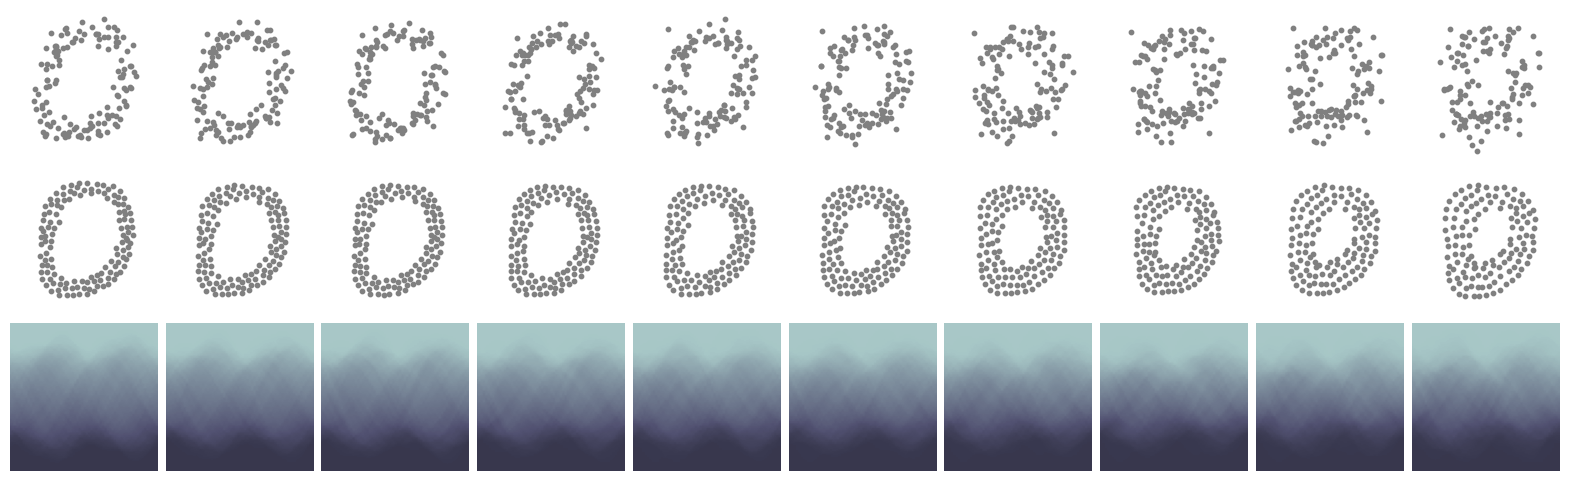

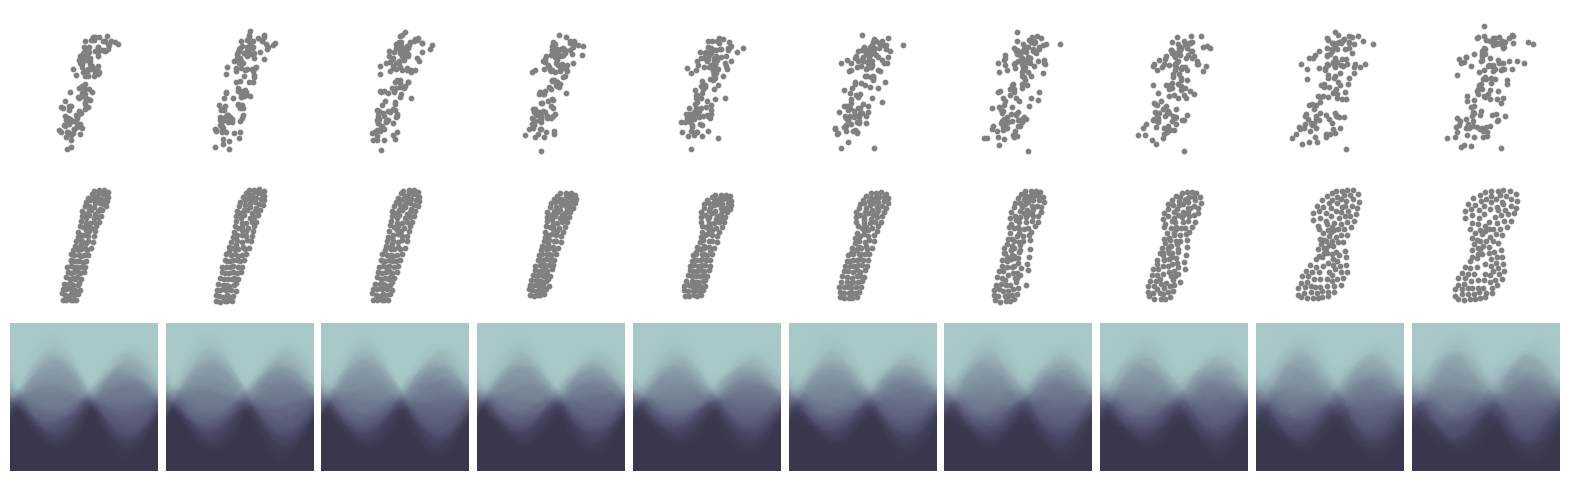

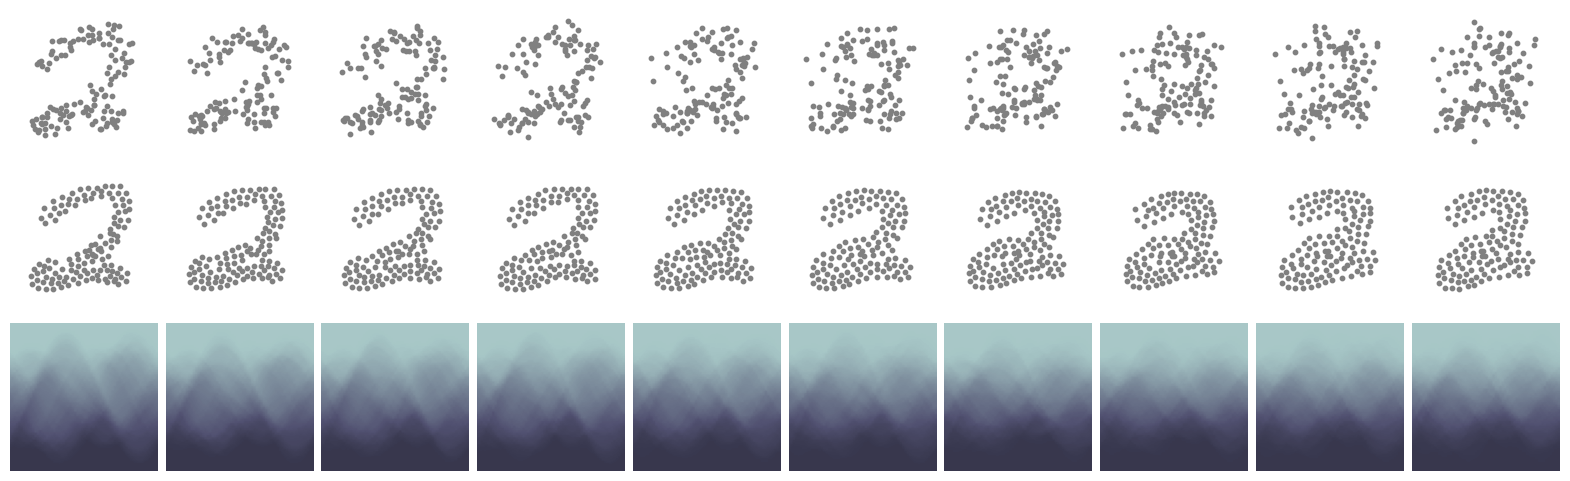

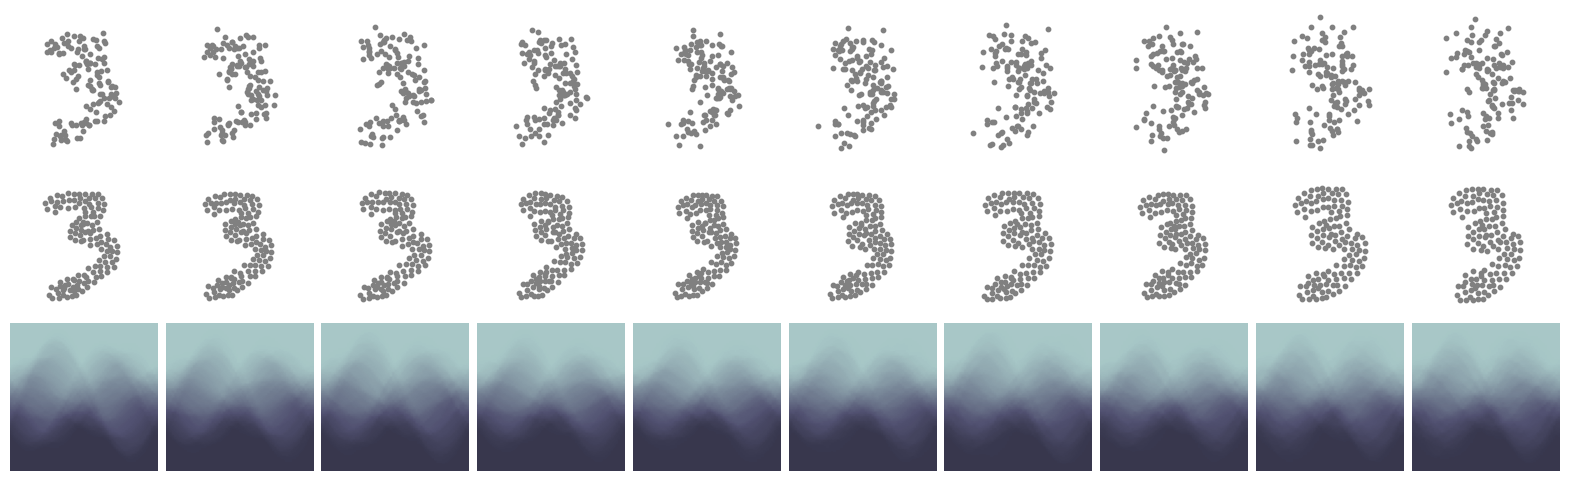

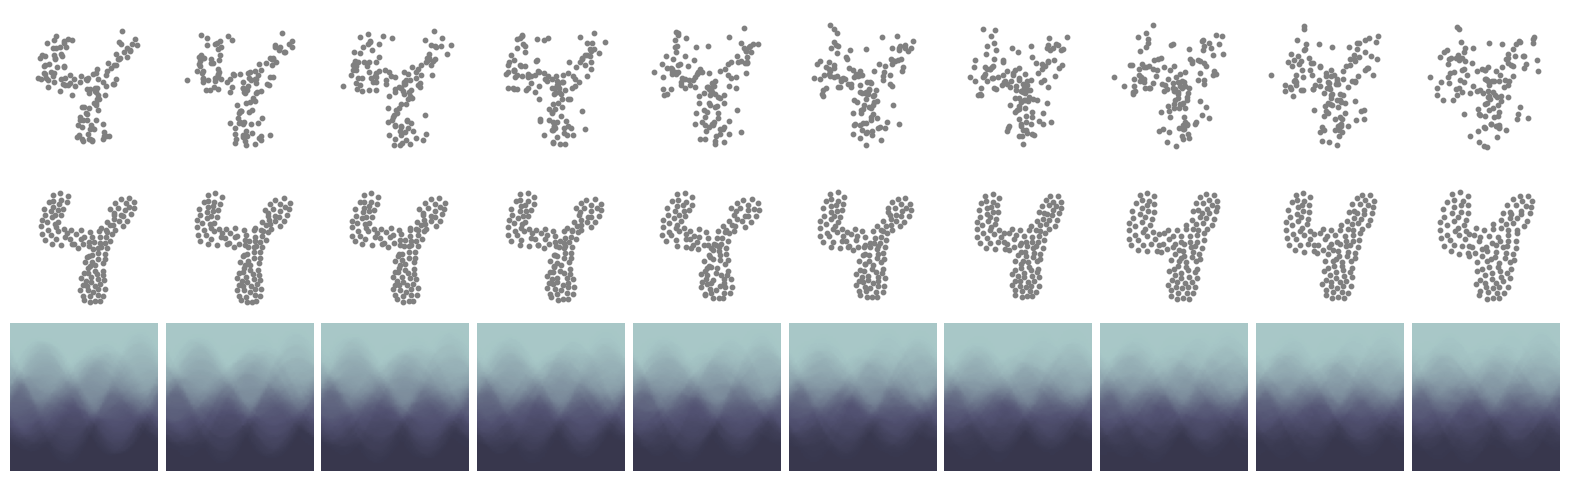

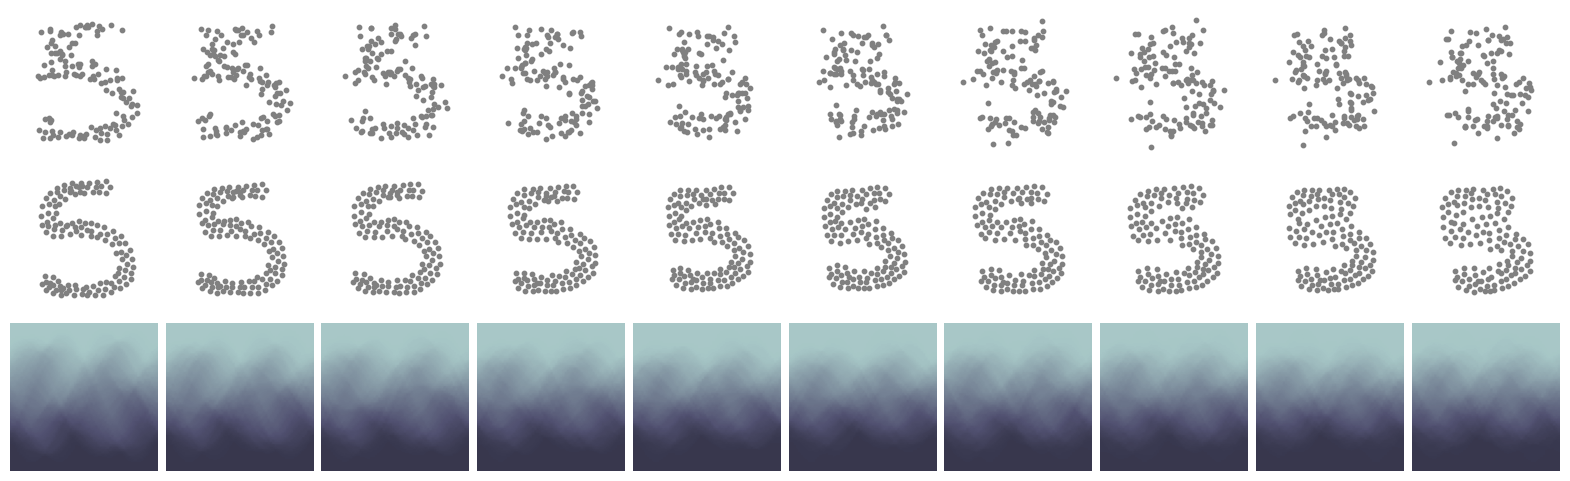

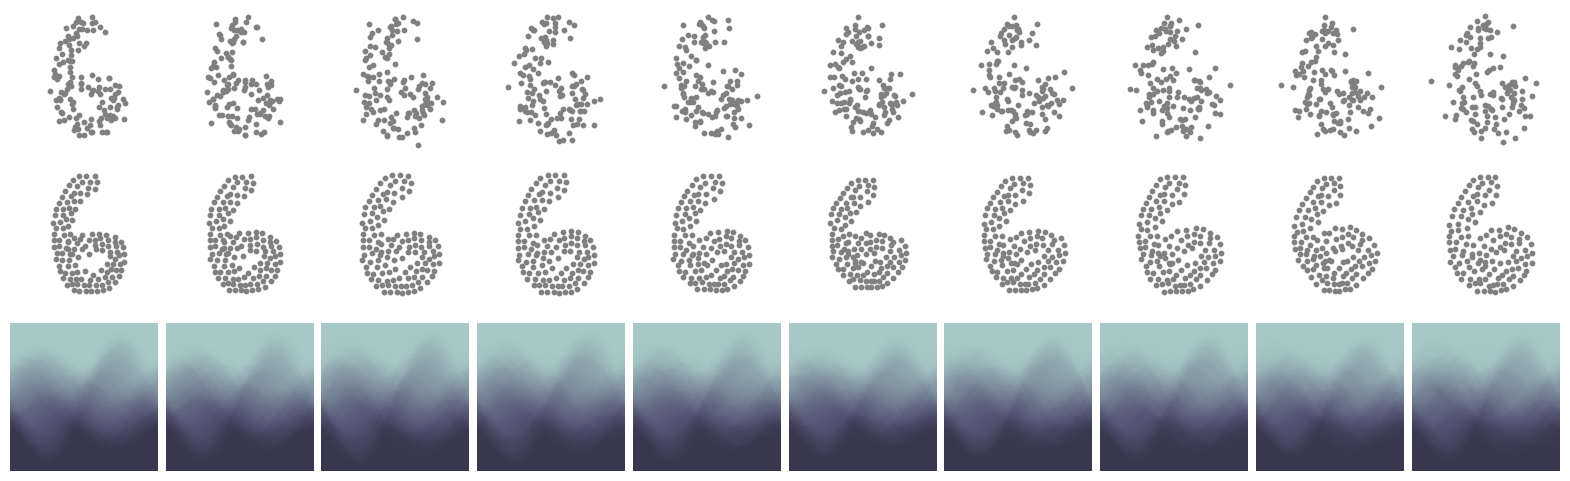

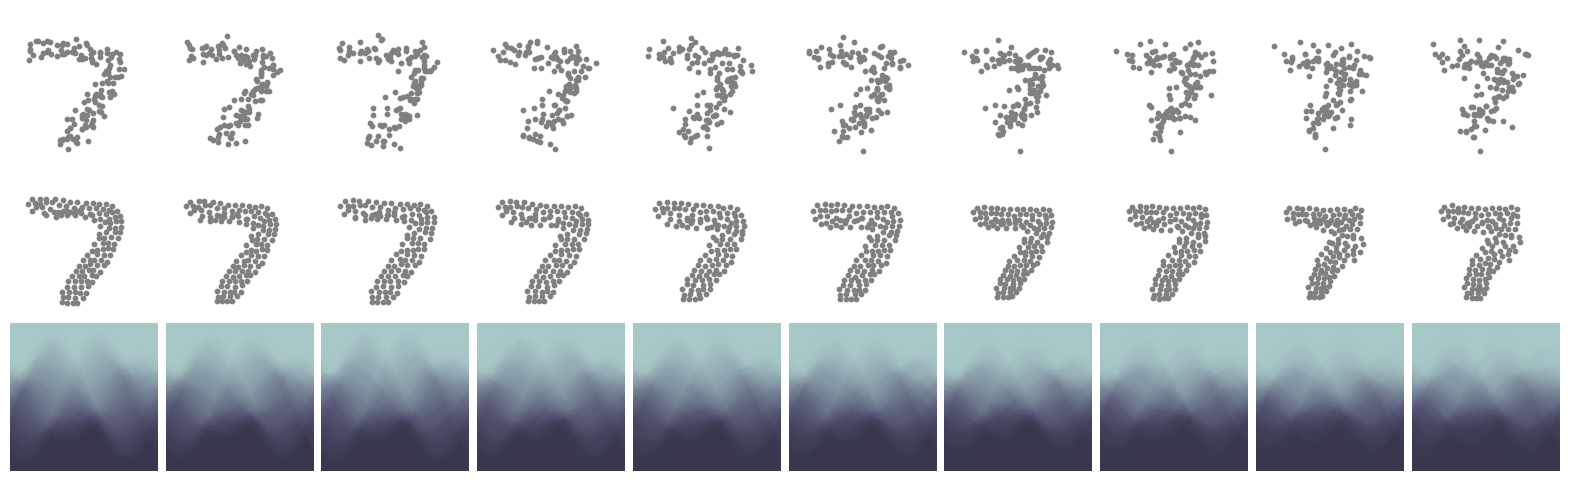

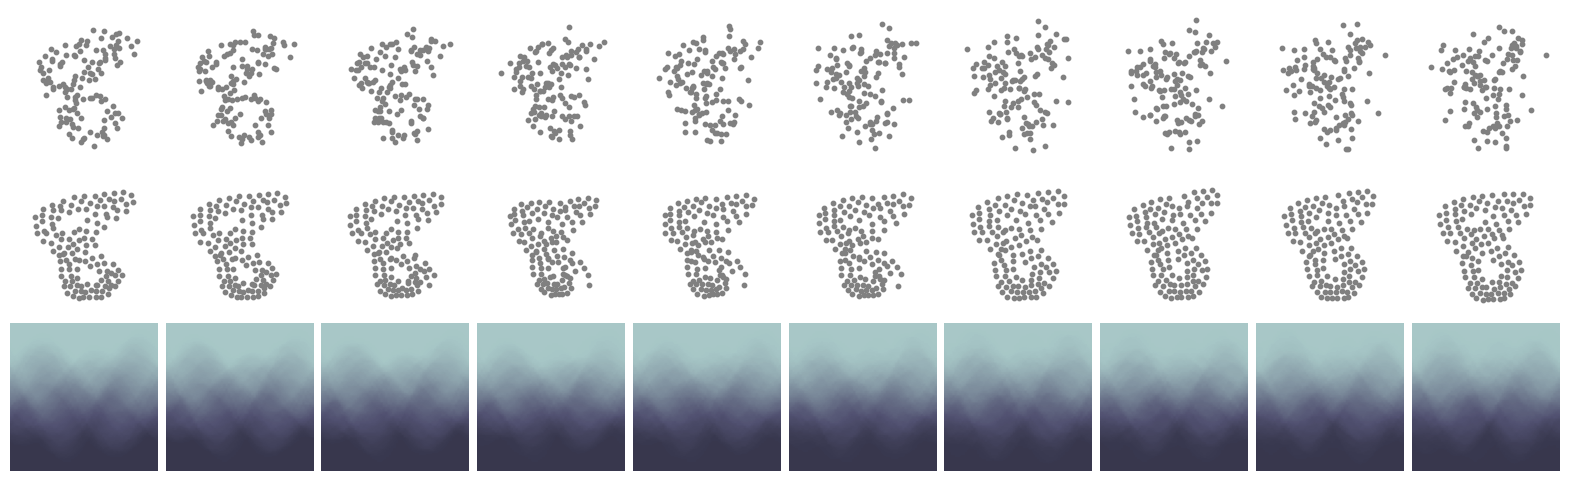

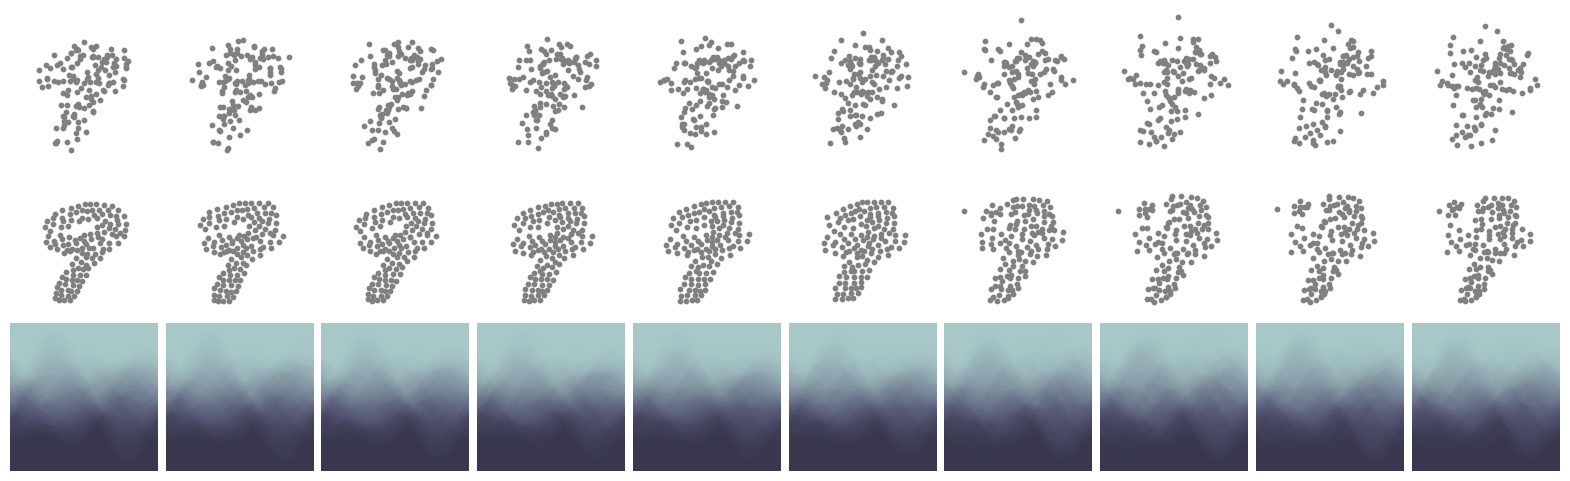

In [ ]:
from datasets.transforms import CenterTransform

ctf = CenterTransform()

for class_idx in range(10):

    data = Data(x=test_batch[class_idx].x)
    pc_list = []
    for _ in range(10):
        data = ctf(Data(x = data.x + .05*torch.randn_like(data.x)))
        pc_list.append(data)

    noise_batch = Batch.from_data_list(pc_list)
    ect = layer(noise_batch,noise_batch.batch).unsqueeze(1)

    # Pass reconstruction through the point cloud decoder

    with torch.no_grad():
        recon_batch = ect_encoder_litmodel.model.forward(ect)


    n_images = 10

    fig, axes = plt.subplots(
        nrows=3, ncols=n_images, figsize=(20,6)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)


    for pts,recon_pts,ect_sample,ax in zip(noise_batch.x.view(-1,128,2),recon_batch,ect,axes.T):
        
        pts = pts.view(-1,2).cpu().detach().squeeze().numpy()
        pts = rotate(pts, degrees=-90)
        
        ax[0].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
        ax[0].set_xlim([-1.1,1.1])
        ax[0].set_ylim([-1.1,1.1])
        ax[0].set_aspect(1)
        ax[0].axis("off")

        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax[1].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax[1].set_xlim([-1.1,1.1])
        ax[1].set_ylim([-1.1,1.1])
        ax[1].set_aspect(1)
        ax[1].axis("off")

        ax[2].imshow(ect_sample.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
        ax[2].set_xlim([0,64])
        ax[2].set_ylim([0,64])
        ax[2].axis("off")

    plt.savefig(f"./figures/img/mnist/stability_ambient_noise_{class_idx}.png",transparent=True)    

In [ ]:
for class_idx in range(10):
    z = torch.hstack([z_mean[class_idx].view(-1,1).cpu().detach(),z_log_var[4].view(-1,1).cpu().detach()])

    print(z.min())
    print(z.max())

    plt.imshow(z.numpy(),cmap="bone",vmin=-4,vmax=1)
    plt.axis("off")

    plt.savefig(f"./figures/img/mnist/latent_{class_idx}.svg",transparent=True)

tensor(-3.7925)
tensor(0.8597)
tensor(-3.7925)
tensor(1.4582)
tensor(-3.7925)
tensor(1.0456)
tensor(-3.7925)
tensor(1.4040)
tensor(-3.7925)
tensor(0.6533)
tensor(-3.7925)
tensor(0.6742)
tensor(-3.7925)
tensor(1.4222)
tensor(-3.7925)
tensor(1.1547)
tensor(-3.7925)
tensor(0.2260)
tensor(-3.7925)
tensor(1.2734)


# Interpolation of the ECT

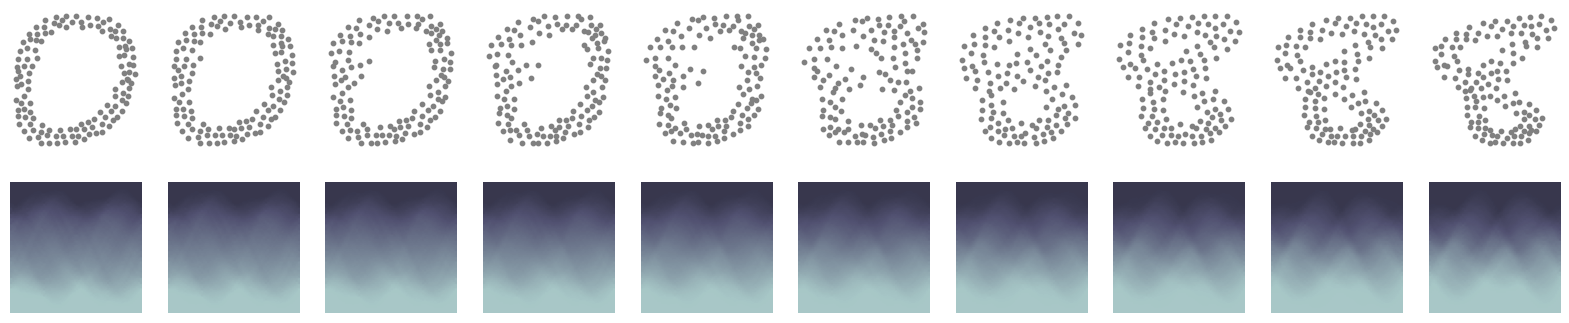

In [ ]:
from torch_geometric.data import Batch,Data
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

test_batch = Batch.from_data_list(data_list).to(DEVICE)

ect = layer(test_batch,test_batch.batch)

start_nr = 8 
end_nr = 0
steps = 10 

ect_start = ect[start_nr].repeat((steps,1,1))
ect_end = ect[end_nr].repeat((steps,1,1))

t = torch.linspace(0,1,steps).view(-1,1,1).cuda()

interpolation_ect = t * ect_start + (1-t)*ect_end

with torch.no_grad():
    interpolation_pts = ect_encoder_litmodel.forward(interpolation_ect.cuda())

fig, axes = plt.subplots(2,steps,figsize=(20,4))


for img, recon_interp, axis in zip(interpolation_ect,interpolation_pts,axes.T):

    pts = recon_interp.view(-1,2).cpu().detach().numpy()
    pts = rotate(pts, degrees=-90)
    ax = axis[0]
    ax.scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
    ax.axis("off")

    ax = axis[1]
    ax.imshow(img.detach().squeeze().cpu().numpy(),**ECT_PLOT_CONFIG)
    ax.axis("off")


plt.savefig("./figures/img/mnist/interpolation.svg",transparent=True)
